In [122]:
import kaggle
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error as mae
from keras.models import *
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt

In [123]:
# Importation des jeux de données
train_df = pd.read_csv("certificatbigdata/train.csv",delimiter=",")
test_df = pd.read_csv("certificatbigdata/test.csv",delimiter=",")
store_df = pd.read_csv("certificatbigdata/store_metadata.csv",delimiter=",")

C:\Users\omabe\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [124]:
train_df

id        date  customers  open  promo state_holliday  \
0       1042  2013-01-01          0     0      0              a   
1        128  2013-01-01          0     0      0              a   
2        420  2013-01-01          0     0      0              a   
3        225  2013-01-01          0     0      0              a   
4        144  2013-01-01          0     0      0              a   
...      ...         ...        ...   ...    ...            ...   
813762   757  2015-07-31        684     1      1              0   
813763   796  2015-07-31        769     1      1              0   
813764   230  2015-07-31       1091     1      1              0   
813765   387  2015-07-31       1402     1      1              0   
813766   935  2015-07-31        802     1      1              0   

        school_holiday      y  
0                    1      0  
1                    1      0  
2                    1      0  
3                    1      0  
4                    1      0  
...                ...    ...  
813762               1   9343  
813763               1   8913  
813764               1  10988  
813765               1  14533  
813766               1   8941  

[813767 rows x 8 columns]

In [125]:
store_df

id store_type assortment    promo_interval
0        1          c          a               NaN
1        2          a          a   Jan,Apr,Jul,Oct
2        3          a          a   Jan,Apr,Jul,Oct
3        4          c          c               NaN
4        5          a          a               NaN
...    ...        ...        ...               ...
1110  1111          a          a   Jan,Apr,Jul,Oct
1111  1112          c          c               NaN
1112  1113          a          c               NaN
1113  1114          a          c               NaN
1114  1115          d          c  Mar,Jun,Sept,Dec

[1115 rows x 4 columns]

# DATA CLEANING

In [126]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 813767 entries, 0 to 813766
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              813767 non-null  int64 
 1   date            813767 non-null  object
 2   customers       813767 non-null  int64 
 3   open            813767 non-null  int64 
 4   promo           813767 non-null  int64 
 5   state_holliday  813767 non-null  object
 6   school_holiday  813767 non-null  int64 
 7   y               813767 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 49.7+ MB


In [127]:
# On remarque que les données d'entrainement ne contiennent pas de valeurs NaN
train_df.isna().sum()

id                0
date              0
customers         0
open              0
promo             0
state_holliday    0
school_holiday    0
y                 0
dtype: int64

In [128]:
# Supprimer les données dupliquées
train_df = train_df.drop_duplicates()

In [129]:
print(f"unique open values :{train_df['open'].unique()}")
print(f"unique promo values :{train_df['promo'].unique()}")
print(f"unique state_holliday values :{train_df['state_holliday'].unique()}")
print(f"unique school_holiday values :{train_df['school_holiday'].unique()}")

unique open values :[0 1]
unique promo values :[0 1]
unique state_holliday values :['a' '0' 'b' 'c' 0]
unique school_holiday values :[1 0]


### state_holliday

In [130]:
# Observer les valeurs possibles de state_holliday
train_df['state_holliday'].value_counts()

0    761641
0     27335
a     16201
b      5322
c      3268
Name: state_holliday, dtype: int64

In [131]:
# Puisque state_holiday est binaire, on considère '0' , 0 => 0 et 'a','b','c' => 1
train_df['state_holliday'] = train_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)
test_df['state_holliday'] = test_df['state_holliday'].apply(lambda x : 0 if str(x)=="0" else 1)

In [132]:
train_df['state_holliday'].value_counts()

0    788976
1     24791
Name: state_holliday, dtype: int64

### Open Var

In [133]:
# Voir si on dispose dans la base de données un magasin ouvert avec un volume des ventes positif
train_df[(train_df['open']==0) & (train_df['y']>0)]

Empty DataFrame
Columns: [id, date, customers, open, promo, state_holliday, school_holiday, y]
Index: []

In [134]:
# Volume de ventes est toujours positif
train_df['y'].min()

0

In [135]:
test_df[(test_df['open']==0) & (test_df['y']>0)]

Empty DataFrame
Columns: [id, date, customers, open, promo, state_holliday, school_holiday, y]
Index: []

In [136]:
test_df['y'].min()

0

In [137]:
# On déduit qu'on pourra nous en passer de l'input 'open' car quand ce n'est pas open la valeur y est nulle

#train_df = train_df.drop(columns=['open'])
#test_df = test_df.drop(columns=['open'])

In [138]:
# Vérifier si la variable Date ne prends pas des valeurs abérrantes

def chack_date(date):
  L = date.split('-')
  return len(L)==3 and len(L[0])==4 and len(L[1])==2 and len(L[2])==2
train_df['date'].apply(chack_date).value_counts()

True    813767
Name: date, dtype: int64

In [139]:
import seaborn as sns

<AxesSubplot:>

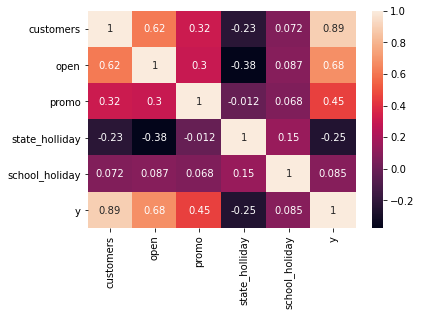

In [140]:
# Corrélation entre la variables; on remarque que le nombre de clients a une grande influence sur la nombre de ventes

sns.heatmap(train_df.drop(columns=['id']).corr(), annot=True)

In [141]:
# On remarque aussi qu'il y a une corrélation linéaire entre 'customers' et 'y'

#pd.plotting.scatter_matrix(train_df.drop(columns=['id','date']).sample(50000), alpha=0.2, figsize=(15,15))

#Feature Eng

In [142]:
display(train_df.head())
display(store_df.head())

id        date  customers  open  promo  state_holliday  school_holiday  y
0  1042  2013-01-01          0     0      0               1               1  0
1   128  2013-01-01          0     0      0               1               1  0
2   420  2013-01-01          0     0      0               1               1  0
3   225  2013-01-01          0     0      0               1               1  0
4   144  2013-01-01          0     0      0               1               1  0

id store_type assortment   promo_interval
0   1          c          a              NaN
1   2          a          a  Jan,Apr,Jul,Oct
2   3          a          a  Jan,Apr,Jul,Oct
3   4          c          c              NaN
4   5          a          a              NaN

In [143]:
# Les valeurs possibles de 'store_type'

store_df['store_type'].value_counts()

a    602
d    348
c    148
b     17
Name: store_type, dtype: int64

In [144]:
# Les valeurs possibles de 'assortment'

store_df['assortment'].value_counts()

a    593
c    513
b      9
Name: assortment, dtype: int64

In [145]:
# Les valeurs possibles de 'promo_interval'

store_df['promo_interval'].value_counts()

Jan,Apr,Jul,Oct     335
Feb,May,Aug,Nov     130
Mar,Jun,Sept,Dec    106
Name: promo_interval, dtype: int64

In [146]:
train_df['promo'].value_counts()

0    503121
1    310646
Name: promo, dtype: int64

### One hot encoding

In [147]:
# Merger les jeux de données train_df et store_df selon l'id en donnant des valeurs binaires pour chaque type de magasin...

train_df_merged = train_df
test_df_merged = test_df
for col in ['store_type', 'assortment', 'promo_interval']:
    df1 = pd.get_dummies(store_df[col], prefix=col[:5])
    df1['id'] = store_df['id']
    train_df_merged = train_df_merged.join(df1.set_index('id'), on='id')
    test_df_merged = test_df_merged.join(df1.set_index('id'), on='id')

train_df_merged


id        date  customers  open  promo  state_holliday  \
0       1042  2013-01-01          0     0      0               1   
1        128  2013-01-01          0     0      0               1   
2        420  2013-01-01          0     0      0               1   
3        225  2013-01-01          0     0      0               1   
4        144  2013-01-01          0     0      0               1   
...      ...         ...        ...   ...    ...             ...   
813762   757  2015-07-31        684     1      1               0   
813763   796  2015-07-31        769     1      1               0   
813764   230  2015-07-31       1091     1      1               0   
813765   387  2015-07-31       1402     1      1               0   
813766   935  2015-07-31        802     1      1               0   

        school_holiday      y  store_a  store_b  store_c  store_d  assor_a  \
0                    1      0        1        0        0        0        1   
1                    1      0        0        0        0        1        0   
2                    1      0        0        0        0        1        0   
3                    1      0        0        0        0        1        1   
4                    1      0        1        0        0        0        0   
...                ...    ...      ...      ...      ...      ...      ...   
813762               1   9343        1        0        0        0        0   
813763               1   8913        1        0        0        0        0   
813764               1  10988        0        0        0        1        0   
813765               1  14533        0        0        1        0        1   
813766               1   8941        1        0        0        0        0   

        assor_b  assor_c  promo_Feb,May,Aug,Nov  promo_Jan,Apr,Jul,Oct  \
0             0        0                      1                      0   
1             0        1                      0                      1   
2             0        1                      0                      1   
3             0        0                      0                      0   
4             0        1                      0                      0   
...         ...      ...                    ...                    ...   
813762        0        1                      0                      0   
813763        0        1                      0                      0   
813764        0        1                      0                      0   
813765        0        0                      0                      0   
813766        0        1                      0                      0   

        promo_Mar,Jun,Sept,Dec  
0                            0  
1                            0  
2                            0  
3                            0  
4                            0  
...                        ...  
813762                       0  
813763                       0  
813764                       0  
813765                       1  
813766                       0  

[813767 rows x 18 columns]

## Some features

In [148]:
#Day of week
train_df_merged['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek
test_df_merged['day_of_week'] = pd.to_datetime(train_df['date']).dt.dayofweek

#Day of year
train_df_merged['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear
test_df_merged['day_of_year'] = pd.to_datetime(train_df['date']).dt.dayofyear

display(train_df_merged)

id        date  customers  open  promo  state_holliday  \
0       1042  2013-01-01          0     0      0               1   
1        128  2013-01-01          0     0      0               1   
2        420  2013-01-01          0     0      0               1   
3        225  2013-01-01          0     0      0               1   
4        144  2013-01-01          0     0      0               1   
...      ...         ...        ...   ...    ...             ...   
813762   757  2015-07-31        684     1      1               0   
813763   796  2015-07-31        769     1      1               0   
813764   230  2015-07-31       1091     1      1               0   
813765   387  2015-07-31       1402     1      1               0   
813766   935  2015-07-31        802     1      1               0   

        school_holiday      y  store_a  store_b  store_c  store_d  assor_a  \
0                    1      0        1        0        0        0        1   
1                    1      0        0        0        0        1        0   
2                    1      0        0        0        0        1        0   
3                    1      0        0        0        0        1        1   
4                    1      0        1        0        0        0        0   
...                ...    ...      ...      ...      ...      ...      ...   
813762               1   9343        1        0        0        0        0   
813763               1   8913        1        0        0        0        0   
813764               1  10988        0        0        0        1        0   
813765               1  14533        0        0        1        0        1   
813766               1   8941        1        0        0        0        0   

        assor_b  assor_c  promo_Feb,May,Aug,Nov  promo_Jan,Apr,Jul,Oct  \
0             0        0                      1                      0   
1             0        1                      0                      1   
2             0        1                      0                      1   
3             0        0                      0                      0   
4             0        1                      0                      0   
...         ...      ...                    ...                    ...   
813762        0        1                      0                      0   
813763        0        1                      0                      0   
813764        0        1                      0                      0   
813765        0        0                      0                      0   
813766        0        1                      0                      0   

        promo_Mar,Jun,Sept,Dec  day_of_week  day_of_year  
0                            0            1            1  
1                            0            1            1  
2                            0            1            1  
3                            0            1            1  
4                            0            1            1  
...                        ...          ...          ...  
813762                       0            4          212  
813763                       0            4          212  
813764                       0            4          212  
813765                       1            4          212  
813766                       0            4          212  

[813767 rows x 20 columns]

In [149]:
# Rajouter les colonnes mean max ... dans le jeu d'entrainement

#stats_sells = train_df_merged.groupby(['id'])['y'].agg(['mean','max','min','std']).copy()
okay = train_df_merged.groupby(['id','day_of_week'])['y'].agg(['mean','max','std']).copy()
display(okay)
#train_df_merged = pd.merge(left = train_df_merged , right = stats_sells.reset_index(), on='id', how ='left')
train_df_merged = pd.merge(left = train_df_merged , right = okay.reset_index(), on=['id','day_of_week'], how ='left')

train_df_merged


mean    max          std
id   day_of_week                                 
1    0            5044.972477   9528  1596.097448
     1            4677.137931   7959  1021.013741
     2            4409.008929   7821  1146.823160
     3            4038.603960   7785  1541.612864
     4            4500.756757   8414  1410.913393
...                       ...    ...          ...
1115 2            5636.920792   9571  1674.879761
     3            5438.931373  11033  2161.930322
     4            6175.936364  11673  2157.608025
     5            6724.768519  10898  1242.714639
     6               0.000000      0     0.000000

[7805 rows x 3 columns]

id        date  customers  open  promo  state_holliday  \
0       1042  2013-01-01          0     0      0               1   
1        128  2013-01-01          0     0      0               1   
2        420  2013-01-01          0     0      0               1   
3        225  2013-01-01          0     0      0               1   
4        144  2013-01-01          0     0      0               1   
...      ...         ...        ...   ...    ...             ...   
813762   757  2015-07-31        684     1      1               0   
813763   796  2015-07-31        769     1      1               0   
813764   230  2015-07-31       1091     1      1               0   
813765   387  2015-07-31       1402     1      1               0   
813766   935  2015-07-31        802     1      1               0   

        school_holiday      y  store_a  store_b  ...  assor_b  assor_c  \
0                    1      0        1        0  ...        0        0   
1                    1      0        0        0  ...        0        1   
2                    1      0        0        0  ...        0        1   
3                    1      0        0        0  ...        0        0   
4                    1      0        1        0  ...        0        1   
...                ...    ...      ...      ...  ...      ...      ...   
813762               1   9343        1        0  ...        0        1   
813763               1   8913        1        0  ...        0        1   
813764               1  10988        0        0  ...        0        1   
813765               1  14533        0        0  ...        0        0   
813766               1   8941        1        0  ...        0        1   

        promo_Feb,May,Aug,Nov  promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  \
0                           1                      0                       0   
1                           0                      1                       0   
2                           0                      1                       0   
3                           0                      0                       0   
4                           0                      0                       0   
...                       ...                    ...                     ...   
813762                      0                      0                       0   
813763                      0                      0                       0   
813764                      0                      0                       0   
813765                      0                      0                       1   
813766                      0                      0                       0   

        day_of_week  day_of_year         mean    max          std  
0                 1            1  4326.831776   7217  1139.326493  
1                 1            1  7339.705357  16662  2382.061809  
2                 1            1  4223.876543   7501  1233.421485  
3                 1            1  5153.433962   9804  1534.362464  
4                 1            1  7325.137500  15852  2118.977958  
...             ...          ...          ...    ...          ...  
813762            4          212  5783.644231  10683  2017.046875  
813763            4          212  6867.689320  11355  2096.613203  
813764            4          212  7424.207207  13177  2050.788315  
813765            4          212  8825.346154  14584  3012.196005  
813766            4          212  5811.546296  11159  1697.486484  

[813767 rows x 23 columns]

In [150]:
#Supprimer la colonne Date 
train_df_new = train_df_merged.drop(columns=['date'])
test_df_new = test_df_merged.drop(columns=['date'])

In [151]:
# Rajouter les colonnes mean max ... dans le jeu de test
features = ['mean','max','std']
test_df_new = pd.merge(left = test_df_new, right = okay[features],on=['id','day_of_week'], how ='left')

train_df_new

id  customers  open  promo  state_holliday  school_holiday      y  \
0       1042          0     0      0               1               1      0   
1        128          0     0      0               1               1      0   
2        420          0     0      0               1               1      0   
3        225          0     0      0               1               1      0   
4        144          0     0      0               1               1      0   
...      ...        ...   ...    ...             ...             ...    ...   
813762   757        684     1      1               0               1   9343   
813763   796        769     1      1               0               1   8913   
813764   230       1091     1      1               0               1  10988   
813765   387       1402     1      1               0               1  14533   
813766   935        802     1      1               0               1   8941   

        store_a  store_b  store_c  ...  assor_b  assor_c  \
0             1        0        0  ...        0        0   
1             0        0        0  ...        0        1   
2             0        0        0  ...        0        1   
3             0        0        0  ...        0        0   
4             1        0        0  ...        0        1   
...         ...      ...      ...  ...      ...      ...   
813762        1        0        0  ...        0        1   
813763        1        0        0  ...        0        1   
813764        0        0        0  ...        0        1   
813765        0        0        1  ...        0        0   
813766        1        0        0  ...        0        1   

        promo_Feb,May,Aug,Nov  promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  \
0                           1                      0                       0   
1                           0                      1                       0   
2                           0                      1                       0   
3                           0                      0                       0   
4                           0                      0                       0   
...                       ...                    ...                     ...   
813762                      0                      0                       0   
813763                      0                      0                       0   
813764                      0                      0                       0   
813765                      0                      0                       1   
813766                      0                      0                       0   

        day_of_week  day_of_year         mean    max          std  
0                 1            1  4326.831776   7217  1139.326493  
1                 1            1  7339.705357  16662  2382.061809  
2                 1            1  4223.876543   7501  1233.421485  
3                 1            1  5153.433962   9804  1534.362464  
4                 1            1  7325.137500  15852  2118.977958  
...             ...          ...          ...    ...          ...  
813762            4          212  5783.644231  10683  2017.046875  
813763            4          212  6867.689320  11355  2096.613203  
813764            4          212  7424.207207  13177  2050.788315  
813765            4          212  8825.346154  14584  3012.196005  
813766            4          212  5811.546296  11159  1697.486484  

[813767 rows x 22 columns]

In [152]:
train_nozero = train_df_new[train_df_new['customers']>0] 
#Retenir que les valeurs non nulles

In [155]:
#remove outliers
train_nozero['ratio'] = train_nozero['y']/train_nozero['customers']
train_groupid = train_nozero.groupby(['id'])
list(train_groupid)

<ipython-input-155-d2ca025281eb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_nozero['ratio'] = train_nozero['y']/train_nozero['customers']


[(1,
          id  customers  open  promo  state_holliday  school_holiday     y  \
  1523     1        668     1      0               0               1  5530   
  2201     1        578     1      0               0               1  4327   
  2788     1        619     1      0               0               1  4486   
  4008     1        635     1      0               0               1  4997   
  5712     1        785     1      1               0               1  7176   
  ...     ..        ...   ...    ...             ...             ...   ...   
  810125   1        612     1      1               0               1  6102   
  811043   1        560     1      1               0               1  5011   
  811852   1        523     1      1               0               1  4782   
  812725   1        546     1      1               0               1  5020   
  813603   1        555     1      1               0               1  5263   
  
          store_a  store_b  store_c  ...  assor_c  promo

In [154]:
zbi lakmelti

SyntaxError: invalid syntax (<ipython-input-154-ab176aea597a>, line 1)

In [109]:
#Rajout du ratio= y/customers

train_group = train_nozero.groupby(['id','day_of_week'])

ratio_df = pd.DataFrame({'ratio_by_dayofweek':train_group['y'].sum()/train_group['customers'].sum()})

train_group_m = pd.merge(left = train_nozero, right = ratio_df ,on=['id','day_of_week'], how ='left')
test_df_new1 = pd.merge(left = test_df_new, right = ratio_df,on=['id','day_of_week'], how ='left')

train_group_m

id  customers  open  promo  state_holliday  school_holiday      y  \
0       274        729     1      0               1               1   3102   
1       335        482     1      0               1               1   2401   
2       769       1248     1      0               1               1   5035   
3        85        619     1      0               1               1   4220   
4       676        777     1      0               1               1   3821   
...     ...        ...   ...    ...             ...             ...    ...   
675501  757        684     1      1               0               1   9343   
675502  796        769     1      1               0               1   8913   
675503  230       1091     1      1               0               1  10988   
675504  387       1402     1      1               0               1  14533   
675505  935        802     1      1               0               1   8941   

        store_a  store_b  store_c  ...  assor_c  promo_Feb,May,Aug,Nov  \
0             0        1        0  ...        0                      0   
1             0        1        0  ...        0                      0   
2             0        1        0  ...        0                      0   
3             0        1        0  ...        0                      0   
4             0        1        0  ...        0                      0   
...         ...      ...      ...  ...      ...                    ...   
675501        1        0        0  ...        1                      0   
675502        1        0        0  ...        1                      0   
675503        0        0        0  ...        1                      0   
675504        0        0        1  ...        0                      0   
675505        1        0        0  ...        1                      0   

        promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  day_of_week  \
0                           1                       0            1   
1                           1                       0            1   
2                           1                       0            1   
3                           0                       0            1   
4                           0                       0            1   
...                       ...                     ...          ...   
675501                      0                       0            4   
675502                      0                       0            4   
675503                      0                       0            4   
675504                      0                       1            4   
675505                      0                       0            4   

        day_of_year          mean    max          std  ratio_by_dayofweek  
0                 1   3438.745455   5930   666.647926            3.942159  
1                 1  15592.963964  28164  4523.966345            5.699577  
2                 1  10240.962264  16458  1804.339757            3.358659  
3                 1   6612.102804   9498  1155.357871            7.255020  
4                 1   7100.844037  11176  1737.744985            4.256071  
...             ...           ...    ...          ...                 ...  
675501          212   5783.644231  10683  2017.046875           11.625640  
675502          212   6867.689320  11355  2096.613203           10.584014  
675503          212   7424.207207  13177  2050.788315            8.097225  
675504          212   8825.346154  14584  3012.196005            7.753565  
675505          212   5811.546296  11159  1697.486484            9.405206  

[675506 rows x 23 columns]

In [110]:
#fill the nan values
train_group_na = train_nozero.groupby(['id'])
ratio_df_na = pd.DataFrame({'ratio_by_dayofweek':train_group_na['y'].sum()/train_group_na['customers'].sum()})
test_df_new1['ratio_by_dayofweek'] = test_df_new1.apply(lambda x: ratio_df_na.loc[x['id']] if x['ratio_by_dayofweek'] != x['ratio_by_dayofweek'] else x['ratio_by_dayofweek'], axis=1)


In [111]:
#Rajout de app_y = ratio_by_dayofweek * customers
train_group_m['app_y'] = train_group_m['customers']*train_group_m['ratio_by_dayofweek']
test_df_new1['app_y'] = test_df_new1['customers']*test_df_new1['ratio_by_dayofweek']

In [112]:
# train_group1 = train_nozero.groupby(['id','promo'])

# ratio_df1 = pd.DataFrame({'ratio_by_promo':train_group1['y'].sum()/train_group1['customers'].sum()})

# train_group_m = pd.merge(left = train_group_m, right = ratio_df1 ,on=['id','promo'], how ='left')
# test_df_new1 = pd.merge(left = test_df_new1, right = ratio_df1,on=['id','promo'], how ='left')

# train_group_m

In [113]:
#Rajout de app_p = ratio_by_promo * customers
#train_group_m['app_p'] = train_group_m['customers']*train_group_m['ratio_by_promo']
#test_df_new1['app_p'] = test_df_new1['customers']*test_df_new1['ratio_by_promo']

In [114]:
test_df_new = test_df_new1
train_df_new = train_group_m

In [115]:
train_df_new

id  customers  open  promo  state_holliday  school_holiday      y  \
0       274        729     1      0               1               1   3102   
1       335        482     1      0               1               1   2401   
2       769       1248     1      0               1               1   5035   
3        85        619     1      0               1               1   4220   
4       676        777     1      0               1               1   3821   
...     ...        ...   ...    ...             ...             ...    ...   
675501  757        684     1      1               0               1   9343   
675502  796        769     1      1               0               1   8913   
675503  230       1091     1      1               0               1  10988   
675504  387       1402     1      1               0               1  14533   
675505  935        802     1      1               0               1   8941   

        store_a  store_b  store_c  ...  promo_Feb,May,Aug,Nov  \
0             0        1        0  ...                      0   
1             0        1        0  ...                      0   
2             0        1        0  ...                      0   
3             0        1        0  ...                      0   
4             0        1        0  ...                      0   
...         ...      ...      ...  ...                    ...   
675501        1        0        0  ...                      0   
675502        1        0        0  ...                      0   
675503        0        0        0  ...                      0   
675504        0        0        1  ...                      0   
675505        1        0        0  ...                      0   

        promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  day_of_week  \
0                           1                       0            1   
1                           1                       0            1   
2                           1                       0            1   
3                           0                       0            1   
4                           0                       0            1   
...                       ...                     ...          ...   
675501                      0                       0            4   
675502                      0                       0            4   
675503                      0                       0            4   
675504                      0                       1            4   
675505                      0                       0            4   

        day_of_year          mean    max          std  ratio_by_dayofweek  \
0                 1   3438.745455   5930   666.647926            3.942159   
1                 1  15592.963964  28164  4523.966345            5.699577   
2                 1  10240.962264  16458  1804.339757            3.358659   
3                 1   6612.102804   9498  1155.357871            7.255020   
4                 1   7100.844037  11176  1737.744985            4.256071   
...             ...           ...    ...          ...                 ...   
675501          212   5783.644231  10683  2017.046875           11.625640   
675502          212   6867.689320  11355  2096.613203           10.584014   
675503          212   7424.207207  13177  2050.788315            8.097225   
675504          212   8825.346154  14584  3012.196005            7.753565   
675505          212   5811.546296  11159  1697.486484            9.405206   

               app_y  
0        2873.834044  
1        2747.196042  
2        4191.606048  
3        4490.857124  
4        3306.966963  
...              ...  
675501   7951.937919  
675502   8139.106862  
675503   8834.072720  
675504  10870.498006  
675505   7542.975005  

[675506 rows x 24 columns]

In [116]:
# Vérifier si train_df_new et test_df_new ne contient au final que des valeurs numériques

train_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())
test_df_new.apply(lambda s: pd.to_numeric(s, errors='coerce').notnull().all())

id                        True
customers                 True
open                      True
promo                     True
state_holliday            True
school_holiday            True
y                         True
store_a                   True
store_b                   True
store_c                   True
store_d                   True
assor_a                   True
assor_b                   True
assor_c                   True
promo_Feb,May,Aug,Nov     True
promo_Jan,Apr,Jul,Oct     True
promo_Mar,Jun,Sept,Dec    True
day_of_week               True
day_of_year               True
mean                      True
max                       True
std                       True
ratio_by_dayofweek        True
app_y                     True
dtype: bool

<AxesSubplot:>

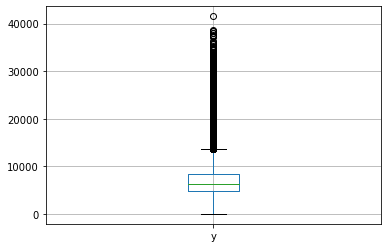

In [117]:
train_df_new.boxplot(column = ['y'])

# Process and Prepare Data

In [118]:
# Separating the features and the target
X , y = train_df_new.drop(columns=['id','y']), train_df_new['y']

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}')
display(X)

Input shape  : (675506, 22)
Target shape : (675506,)


customers  open  promo  state_holliday  school_holiday  store_a  \
0             729     1      0               1               1        0   
1             482     1      0               1               1        0   
2            1248     1      0               1               1        0   
3             619     1      0               1               1        0   
4             777     1      0               1               1        0   
...           ...   ...    ...             ...             ...      ...   
675501        684     1      1               0               1        1   
675502        769     1      1               0               1        1   
675503       1091     1      1               0               1        0   
675504       1402     1      1               0               1        0   
675505        802     1      1               0               1        1   

        store_b  store_c  store_d  assor_a  ...  promo_Feb,May,Aug,Nov  \
0             1        0        0        0  ...                      0   
1             1        0        0        1  ...                      0   
2             1        0        0        0  ...                      0   
3             1        0        0        1  ...                      0   
4             1        0        0        0  ...                      0   
...         ...      ...      ...      ...  ...                    ...   
675501        0        0        0        0  ...                      0   
675502        0        0        0        0  ...                      0   
675503        0        0        1        0  ...                      0   
675504        0        1        0        1  ...                      0   
675505        0        0        0        0  ...                      0   

        promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  day_of_week  \
0                           1                       0            1   
1                           1                       0            1   
2                           1                       0            1   
3                           0                       0            1   
4                           0                       0            1   
...                       ...                     ...          ...   
675501                      0                       0            4   
675502                      0                       0            4   
675503                      0                       0            4   
675504                      0                       1            4   
675505                      0                       0            4   

        day_of_year          mean    max          std  ratio_by_dayofweek  \
0                 1   3438.745455   5930   666.647926            3.942159   
1                 1  15592.963964  28164  4523.966345            5.699577   
2                 1  10240.962264  16458  1804.339757            3.358659   
3                 1   6612.102804   9498  1155.357871            7.255020   
4                 1   7100.844037  11176  1737.744985            4.256071   
...             ...           ...    ...          ...                 ...   
675501          212   5783.644231  10683  2017.046875           11.625640   
675502          212   6867.689320  11355  2096.613203           10.584014   
675503          212   7424.207207  13177  2050.788315            8.097225   
675504          212   8825.346154  14584  3012.196005            7.753565   
675505          212   5811.546296  11159  1697.486484            9.405206   

               app_y  
0        2873.834044  
1        2747.196042  
2        4191.606048  
3        4490.857124  
4        3306.966963  
...              ...  
675501   7951.937919  
675502   8139.106862  
675503   8834.072720  
675504  10870.498006  
675505   7542.975005  

[675506 rows x 22 columns]

In [119]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardizing the features
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

#power = PowerTransformer(method='yeo-johnson', standardize=True)
#X_train = power.fit_transform(X_train)
#X_valid = power.transform(X_valid)
#X_test = power.transform(test_df_new.drop(columns=['id','y']))

X_train= X_train.to_numpy()
X_valid= X_valid.to_numpy()
y_train= y_train.to_numpy()
y_valid= y_valid.to_numpy()


# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
#print(f'Test size : {X_test.shape[0]}')

Train size : 540404
Validation size : 135102


# Train Models Pipeline

In [120]:
Models = dict()

In [121]:
def train_model_grid_search(model_name, model, grid, train_data=(X_train,y_train), valid_data=(X_valid,y_valid),
                            eval_metric='neg_mean_absolute_error', save_dict=Models, verbose=1):
    """
    model_name : Name of the model
    model : sklearn model
    grid : Hyper parameters search grid
    train_data : (train inputs, train outputs)
    eval_metric : evaluation metric in the grid search
    ------------------
    Trains model on training data using a grid search and cross validation then saves trained model in save_dict
    """
    model_cv = GridSearchCV(model, grid, scoring=eval_metric, cv=3)
    model_cv.fit(X_train, y_train)
    train_preds, valid_preds = model_cv.predict(X_train) , model_cv.predict(X_valid)
    #train_preds, valid_preds = np.maximum(train_preds,0) , np.maximum(valid_preds,0)
    save_dict[model_name] = {'model':model_cv,
                             'scores':{'train': mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)
                                       }}
    if verbose ==1:
        print(f" -  {model_name} best hyperparameters : {model_cv.best_params_}",'\n\n')
        print(f" -  {model_name} results on the train set:" )
        print(mae(y_train, train_preds))
        print(f" -  {model_name} results on the valid set:")
        print(mae(y_valid, valid_preds))
        

### Linear Regression

In [436]:
train_model_grid_search(model_name = 'Linear Regression',
                        model = LinearRegression(),
                        grid = {'fit_intercept':[True,False], 
                                'copy_X':[True, False],
                                'normalize':[True,False]})

 -  Linear Regression best hyperparameters : {'copy_X': True, 'fit_intercept': True, 'normalize': False} 


 -  Linear Regression results on the train set:
357.1879552249296
 -  Linear Regression results on the valid set:
358.8769569812214


### Decision trees


In [446]:
train_model_grid_search(model_name = 'Decision Tree Regression',
                        model = DecisionTreeRegressor(random_state = 42),
                        grid = {'max_depth':list(range(5,20,4)),'min_samples_leaf':range(1,10,2)
                                })

 -  Decision Tree Regression best hyperparameters : {'max_depth': 13, 'min_samples_leaf': 9} 


 -  Decision Tree Regression results on the train set:
308.60983068456545
 -  Decision Tree Regression results on the valid set:
329.269930988634


### Random Forest

In [448]:
train_model_grid_search(model_name = 'Random Forest Regression',
                        model = RandomForestRegressor(min_samples_split=2, random_state = 42, min_samples_leaf=9, max_depth=13),  grid={}
                        #grid = {'max_depth': range(10,100,30),
                        #        'min_samples_leaf':range(2,10,3),
                        #        'n_estimators': [100, 200, 300]}
                        )

KeyboardInterrupt: 

### K-NN

In [ ]:
train_model_grid_search(model_name = 'K-NN',
                        model = KNeighborsRegressor(),
                        grid = {#'n_neighbors':range(1,7),
                                #'weights':['uniform','distance'],
                                })

### XGBoost

In [1]:
train_model_grid_search(model_name = 'XGBoost',
                        model = XGBRegressor(),
                        grid = {'max_depth': [3, 4, 5, 6, 7]})

NameError: name 'train_model_grid_search' is not defined

### SVM

In [ ]:
train_model_grid_search(model_name = 'SVM',
                        model = SVR(),
                        grid = {#'C':[0.01, 1, 10],
#                                 'gamma':[0.001, 0.01, 0.1, 1],
                                'kernel':['linear']})

### Neural Network

In [142]:
# Separating the features and the target
X, y = train_df_new.drop(columns=['y', 'id']), train_df_new['y']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Print input/target format 
print(f'Input shape  : {X.shape}')
print(f'Target shape : {y.shape}\n')
print(f'Target : \n{y}')

Input shape  : (813767, 17)
Target shape : (813767,)

Target : 
0             0
1             0
2             0
3             0
4             0
          ...  
813762     9343
813763     8913
813764    10988
813765    14533
813766     8941
Name: y, Length: 813767, dtype: int64


In [143]:
# Split to train and test 
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = scaler.transform(test_df_new.drop(columns=['y', 'id']))

# Print Data size
print(f'Train size : {X_train.shape[0]}')
print(f'Validation size : {X_valid.shape[0]}')
print(f'Test size : {X_test.shape[0]}')

Train size : 651013
Validation size : 162754
Test size : 203442


In [144]:
# create model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='softplus'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear'))
# Compile model
model.compile(loss='mean_absolute_error', optimizer=Adam(learning_rate=0.0001), metrics=['mean_absolute_error'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                576       
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2

In [145]:
# Training params
nb_epochs = 50
model_hist = model.fit(x=X_train, y=y_train, validation_data=(X_valid,y_valid), batch_size=32, epochs=nb_epochs, verbose=1).history

Epoch 1/50
20345/20345 [==============================] - 74s 4ms/step - loss: 2376.1564 - mean_absolute_error: 2376.1564 - val_loss: 885.9729 - val_mean_absolute_error: 885.9729
Epoch 2/50
20345/20345 [==============================] - 77s 4ms/step - loss: 1344.1995 - mean_absolute_error: 1344.1995 - val_loss: 809.8192 - val_mean_absolute_error: 809.8192
Epoch 3/50
20345/20345 [==============================] - 80s 4ms/step - loss: 1290.5656 - mean_absolute_error: 1290.5656 - val_loss: 805.1924 - val_mean_absolute_error: 805.1924
Epoch 4/50
20345/20345 [==============================] - 81s 4ms/step - loss: 1273.0626 - mean_absolute_error: 1273.0626 - val_loss: 792.6286 - val_mean_absolute_error: 792.6286
Epoch 5/50
20345/20345 [==============================] - 78s 4ms/step - loss: 1268.1528 - mean_absolute_error: 1268.1528 - val_loss: 798.6401 - val_mean_absolute_error: 798.6401
Epoch 6/50
20345/20345 [==============================] - 81s 4ms/step - loss: 1262.0179 - mean_absolute_

In [153]:
##Prediction
train_preds = model.predict(X_train)
valid_preds = model.predict(X_valid)
Models['Neural Network'] = {'model':model,
                             'scores':{'train':mae(y_train, train_preds),
                                       'valid' :mae(y_valid, valid_preds)}}
print("   -   MAE on the train set : {:.2f}".format(Models['Neural Network']['scores']['train']))
print("   -   MAE on the test set : {:.2f}".format(Models['Neural Network']['scores']['valid']))

   -   MAE on the train set : 767.65
   -   MAE on the test set : 763.41


# Approch Results

<AxesSubplot:>

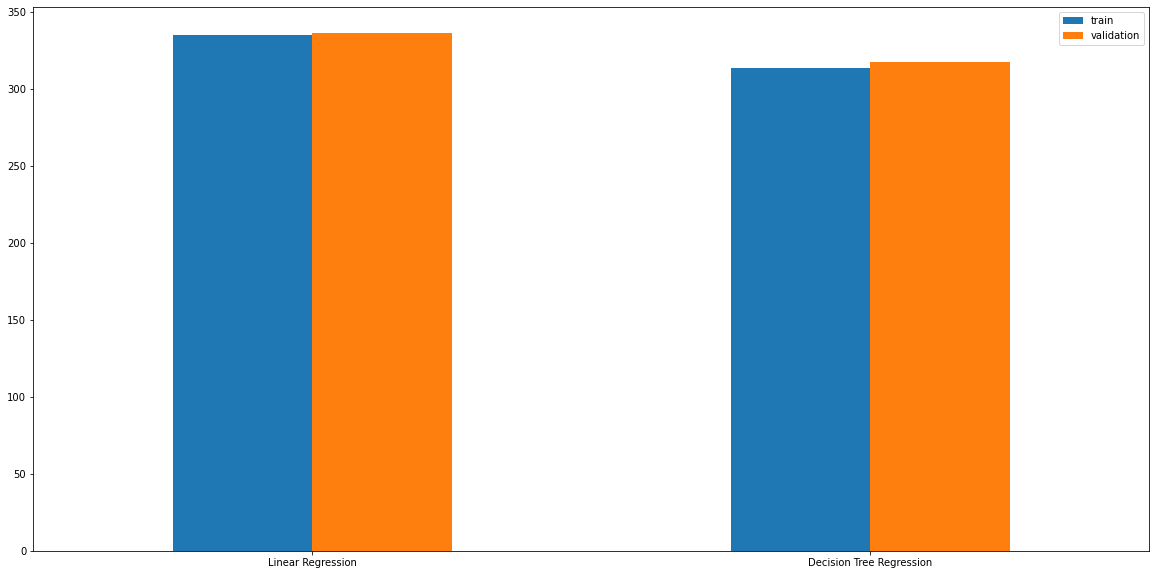

In [49]:
df_results_1 = pd.DataFrame([[model['scores']['train'],model['scores']['valid']] for model_name,model in Models.items()],
                           columns=['train', 'validation'],
                           index=list(Models.keys()))

df_results_1.plot.bar(rot=0, figsize=(20,10))

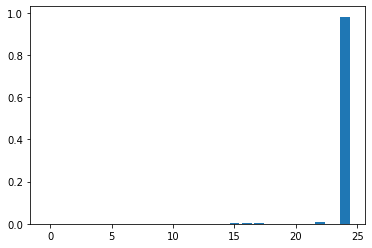

In [456]:
# visualize feature importance scores 
model = Models['Decision Tree Regression']['model'].best_estimator_
importance = model.feature_importances_
# for i,v in enumerate(importance):
#     print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## BEST MODEL - trained on both train and valid set

In [885]:
best_model = DecisionTreeRegressor(max_depth= 13, min_samples_leaf= 9)
#best_model = LinearRegression(**Models['Linear Regression']['model'].best_params_)
#best_model = RandomForestRegressor(min_samples_split=2, random_state = 42, min_samples_leaf=9, max_depth=13)
#best_model = XGBRegressor(max_depth=5)
#best_model = SVR(kernel='linear')

In [886]:
# X désigne X_train et X_valid concaténé

#Scaling
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(test_df_new.drop(columns=['id','y']))

#Power
#power = PowerTransformer(method='yeo-johnson', standardize=True)
#X = power.fit_transform(X) 
#X_test = power.transform(test_df_new.drop(columns=['id','y']))

X_test = test_df_new.drop(columns=['id','y'])
X_test

customers  open  promo  state_holliday  school_holiday  store_a  \
0               0     0      0               1               1        0   
1               0     0      0               1               1        1   
2               0     0      0               1               1        0   
3               0     0      0               1               1        1   
4               0     0      0               1               1        1   
...           ...   ...    ...             ...             ...      ...   
203437        542     1      1               0               1        0   
203438        716     1      1               0               1        0   
203439        806     1      1               0               1        0   
203440        575     1      1               0               1        1   
203441        721     1      1               0               1        1   

        store_b  store_c  store_d  assor_a  assor_b  assor_c  \
0             0        1        0        0        0        1   
1             0        0        0        1        0        0   
2             0        0        1        0        0        1   
3             0        0        0        1        0        0   
4             0        0        0        0        0        1   
...         ...      ...      ...      ...      ...      ...   
203437        0        0        1        1        0        0   
203438        0        0        1        0        0        1   
203439        0        1        0        0        0        1   
203440        0        0        0        1        0        0   
203441        0        0        0        1        0        0   

        promo_Feb,May,Aug,Nov  promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  \
0                           1                      0                       0   
1                           0                      1                       0   
2                           0                      0                       1   
3                           1                      0                       0   
4                           0                      0                       0   
...                       ...                    ...                     ...   
203437                      0                      1                       0   
203438                      1                      0                       0   
203439                      0                      0                       0   
203440                      0                      0                       1   
203441                      0                      1                       0   

        day_of_week  day_of_year         mean    max          std  \
0                 1            1  4385.796296   8741  1490.567544   
1                 1            1  4549.681818   7904  1051.731605   
2                 1            1  5850.425926  12214  1763.165851   
3                 1            1  7642.980198  13123  1945.761933   
4                 1            1  6685.594828  11456  1444.323046   
...             ...          ...          ...    ...          ...   
203437            5          229  5529.873874   8318   989.136365   
203438            5          229  7331.728155  11892  1311.745007   
203439            5          229  6710.771429  11540  1353.342339   
203440            5          229  2237.394495   4001   399.596811   
203441            5          229  3038.028571   5473   730.326672   

       ratio_by_dayofweek    app_y  ratio_by_promo        app_p  
0                 8.88646        0        8.261243     0.000000  
1                  9.3558        0        8.897329     0.000000  
2                 14.5738        0       13.723575     0.000000  
3                 9.02222        0        8.269927     0.000000  
4                 7.37279        0        6.863354     0.000000  
...                   ...      ...             ...          ...  
203437            11.3426  6147.69       12.093447  6554.648053  
203438            11

In [887]:
#Entrainement
best_model.fit(X,y)

DecisionTreeRegressor(max_depth=13, min_samples_leaf=9)

In [888]:
test_preds = X_test.apply(lambda x: 0 if x['customers']==0 else best_model.predict(np.array([x.to_numpy()]))[0], axis = 1)
#X_test[:500].apply(lambda x: 0 if x['customers']==0 else best_model.predict(np.array([x.to_numpy()]))[0], axis = 1)

#Prediction
#test_preds = best_model.predict(X_test)
test_preds

0            0.000000
1            0.000000
2            0.000000
3            0.000000
4            0.000000
             ...     
203437    5983.346939
203438    8439.719064
203439    5812.846154
203440    4445.131579
203441    6055.231343
Length: 203442, dtype: float64

In [889]:
#MAE
display(mae(y, best_model.predict(X)))
pd.set_option('display.max_columns', None)

309.7010279842752

In [835]:
y_pred = best_model.predict(X)
X1 = X
X1['abs_error'] = np.abs(y-y_pred)
X1['y'], X1['y_pred'] = y , y_pred
X1 = X1.sort_values(by=['abs_error'], ascending=False)
X1

customers  open  promo  state_holliday  school_holiday  store_a  \
220204        574     1      1               0               1        0   
644376       1721     1      0               0               0        1   
218791        554     1      1               0               1        0   
200895        613     1      1               0               0        0   
225215        833     1      0               0               1        1   
...           ...   ...    ...             ...             ...      ...   
205311       1866     1      0               0               1        0   
45931         517     1      0               0               0        1   
254117        343     1      0               0               0        1   
233671       1925     1      0               0               0        1   
436560        730     1      1               0               0        0   

        store_b  store_c  store_d  assor_a  assor_b  assor_c  \
220204        0        0        1        1        0        0   
644376        0        0        0        0        0        1   
218791        0        0        1        1        0        0   
200895        0        0        1        1        0        0   
225215        0        0        0        1        0        0   
...         ...      ...      ...      ...      ...      ...   
205311        0        1        0        0        0        1   
45931         0        0        0        1        0        0   
254117        0        0        0        1        0        0   
233671        0        0        0        1        0        0   
436560        0        0        1        0        0        1   

        promo_Feb,May,Aug,Nov  promo_Jan,Apr,Jul,Oct  promo_Mar,Jun,Sept,Dec  \
220204                      1                      0                       0   
644376                      1                      0                       0   
218791                      1                      0                       0   
200895                      1                      0                       0   
225215                      0                      1                       0   
...                       ...                    ...                     ...   
205311                      0                      0                       0   
45931                       0                      0                       0   
254117                      0                      1                       0   
233671                      0                      0                       0   
436560                      0                      1                       0   

        day_of_week  day_of_year          mean    max          std  \
220204            3          297   5755.281553  33071  3760.394166   
644376            0          173  11753.250000  41551  5994.609506   
218791            1          295   6548.740741  30619  3680.039045   
200895            4          270   6172.070796  27050  2964.764224   
225215            2          303   6802.969388  24888  2572.137290   
...             ...          ...           ...    ...          ...   
205311            4          277  11722.953271  30143  5036.600417   
45931             5           61   5101.268041   7842   748.571675   
254117            5          341   2864.986301   4982   401.164053   
233671            0          315  19853.108911  31094  5599.953591   
436560            3          233   7517.027778  14580  2820.176154   

        ratio_by_dayofweek         app_y     abs_error      y        y_pred  
220204           12.034227   6907.646440  22353.428571  33071  10717.571429  
644376           11.036141  18993.198259  20561.727273  41551  20989.272727  
218791           12.371676   6853.908760  19901.428571  30619  10717.571429  
200895           11.401733   6989.262253  18700.000000  27050   8350.000000  
225215            8.583083   7149.708439  16830.000000  24888   8058.000000  
...                    ...           ...           ...    ...       

In [836]:
pd.set_option('display.max_columns', None)

In [837]:
X1['ratio_actual'] = X1['y'] / X1['customers']

In [838]:
X1.head(60)

customers  open  promo  state_holliday  school_holiday  store_a  \
220204        574     1      1               0               1        0   
644376       1721     1      0               0               0        1   
218791        554     1      1               0               1        0   
200895        613     1      1               0               0        0   
225215        833     1      0               0               1        1   
650067       1370     1      1               0               0        1   
181677        529     1      0               0               1        0   
223976        474     1      0               0               1        0   
181033        261     1      0               0               0        0   
222457        413     1      0               0               0        0   
168080        386     1      1               0               1        0   
177260        571     1      1               0               1        0   
216707        331     1      0               0               0        0   
412490       1308     1      1               0               1        1   
542223       1564     1      1               0               0        1   
210118        402     1      1               0               1        0   
547351       1291     1      0               0               0        0   
443698       1846     1      1               0               0        1   
119900       1694     1      0               0               0        1   
392861       1970     1      1               0               0        0   
229174        768     1      1               0               0        0   
224771       1181     1      0               0               0        1   
655706       1653     1      0               0               0        1   
440450       1220     1      0               0               1        1   
373853       1585     1      1               0               0        1   
393108       1930     1      1               0               0        0   
439711        998     1      0               0               1        1   
230050        703     1      1               0               0        0   
645600       1635     1      0               0               0        1   
548710       1418     1      0               0               0        0   
373155       1637     1      1               0               0        1   
162131        505     1      0               0               1        1   
650501       1322     1      1               0               0        1   
442823       1876     1      1               0               0        1   
522037       1367     1      1               0               1        1   
175431        757     1      1               0               1        0   
522789       1386     1      1               0               1        1   
199877        689     1      1               0               0        0   
643236       1214     1      0               0               0        1   
152750        476     1      0               0               1        0   
441088       1185     1      0               0               1        1   
654078        598     1      0               0               0        1   
215844        508     1      0               0               0        1   
60704         784     1      1               0               0        0   
84890         244     1      1               0               0        0   
209209       1326     1      1               0               0        1   
143671       1758     1      1               0               1        1   
599738       1251     1      0               0               0        0   
172176       1278     1      0               0               1        1   
192214        216     1      0               0               0        0   
583270       2392     1      0               0               0        1   
432022        727     1      0               0               1        0   
225681        716     1      0   

In [839]:
X1['abs_error'].describe()
#X1.boxplot(column='abs_error')

count    675506.000000
mean        305.929359
std         309.681526
min           0.000000
25%         107.266398
50%         232.348816
75%         415.562422
max       22353.428571
Name: abs_error, dtype: float64

## Save as .csv

In [454]:
d = {'y': test_preds}
result = pd.DataFrame(data=d)
result.index.names = ['index']
result

y
index              
0          0.000000
1          0.000000
2          0.000000
3          0.000000
4          0.000000
...             ...
203437  6136.111528
203438  8430.878318
203439  6131.588634
203440  4702.196085
203441  6079.787661

[203442 rows x 1 columns]

In [455]:
result.to_csv('solution.csv',encoding='ISO-8859-1', sep=',')